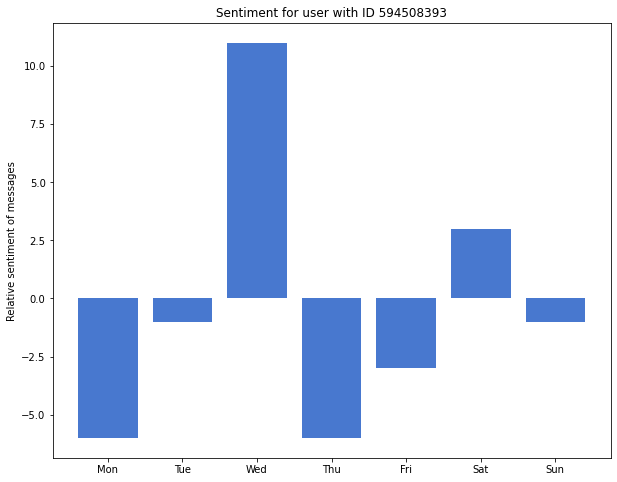

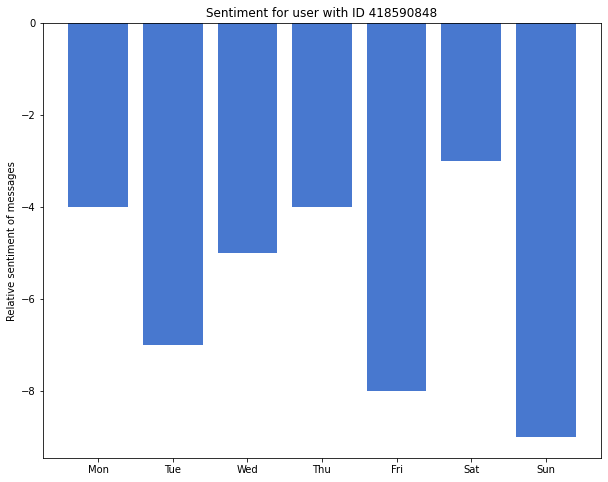

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

data = pd.read_csv("data/dialogs/594508393.csv")

def tsv_to_dict(tsv_path="tone-dict-uk.tsv"):
    """
    Convert downloaded .tsv with word tonality to
    python dict
    """
    sentiment_data = pd.read_csv("tone-dict-uk.tsv", sep="\t")
    sentiment_dict = dict(zip(sentiment_data.iloc[:, 0], sentiment_data.iloc[:, 1]))

    return sentiment_dict 
    
    
def is_date_after(check_date, days_ago = 365):
    """
    Check if {days_ago} date < {check_date} < current date
    """
    date_today = datetime.now(timezone.utc)
    days_ago = timedelta(days = days_ago)
    final_date = date_today - days_ago
    if check_date > final_date:
        return True
    return False


def divide_and_prepare_data(data, days_ago = 365):
    """
    Divide messages by User and Day of the week
    """
    prepped_data = {}
    for index, row in data.iterrows():
        
        msg_date = datetime.fromisoformat(row['date'])
        if not is_date_after(msg_date, days_ago):
            break
        if not row['from_id'] in prepped_data:
            prepped_data[row['from_id']] = {
                day_num : set() for day_num in range(1, 8)
            }
        
        msg_week_day = msg_date.isoweekday()
        prepped_data[row['from_id']][msg_week_day].add(row['message'])
        
    return prepped_data
    
    
def sentiment_text_analysis(data, sentiment_dict_path="tone-dict-uk.tsv"):
    """
    Calculate sentiment of each word, and store the result
    as a sentiment for a specific week day (of a specific user)
    
    P.S Messages that are not in word_dict are perceived as Neutral (sentiment = 0)
    """
    sentiment_result = {}
    text_data = divide_and_prepare_data(data)
    word_dict = tsv_to_dict(sentiment_dict_path)
    for user_id in text_data:
        
        if not user_id in sentiment_result:
            sentiment_result[user_id] = {
                day_num : 0 for day_num in range(1, 8)
            }
        
        for day_number in text_data[user_id]:
            
            score = 0
            
            while text_data[user_id][day_number]:
                
                msg = text_data[user_id][day_number].pop()

                if isinstance(msg, str):
                    tokens = msg.strip().split()
                    for token in tokens:
                        if token.lower() in word_dict:
                            score += word_dict[token.lower()]
                 
            sentiment_result[user_id][day_number] = score
            
            
    return sentiment_result
    
    
def plot_sentiment_analysis_results(result_data):
    
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    for user_id, sentiment_info in result_data.items():
            
        sentiment_values = list(sentiment_info.values())
        positions = list(sentiment_info.keys())
        
        fig = plt.figure(figsize=(10,8))
        plt.style.use("seaborn-muted")
        plt.bar(positions, sentiment_values)
        plt.ylabel('Relative sentiment of messages')
        plt.xticks(positions, days)
        plt.title(f"Sentiment for user with ID {user_id}")
        plt.show()


plot_sentiment_analysis_results(res)


